# Handheld VESAD - Data visualization and analysis

## Load and prepare the data

### Configuration

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

from pandas.api.types import CategoricalDtype
from matplotlib import pyplot as plt
from statsmodels.formula.api import ols

from ast import literal_eval
from os import listdir
from os.path import join

%matplotlib inline
sns.set_style('whitegrid')
sns.set_context('paper')

### Load the csv data files

The participants information are in `participants`, all the trials in `trials`, and the detailled mesures of the trials in `trial_details`.

In [107]:
participants = pd.read_csv('participants.csv')
trials = pd.read_csv('participants_trials.csv')

# Detailled trials are long to load, keep commented if unused
#trial_details = []
#for file in listdir('.'):
#    if file.endswith('details.csv'): # The trial files end with *-details.csv
#        details.append(pd.read_csv(file))
#trial_details = pd.concat(details, ignore_index=True)

### Reshape the data to be more useful

Utilities to analyse and display the data:

In [503]:
participant_ids = list(range(participants.shape[0]))

counts = pd.DataFrame(index=['rates', 'preferences'], columns=['questions', 'scale', 'palette', 'values'])

counts.at['rates', 'questions'] = pd.DataFrame(index=participants.loc[:, 'easy_understand':'frustration'].columns, columns=['name'], data=['Easy to Understand', 'Mentally Easy to Use', 'Physically Easy to Use', 'Subjective Speed', 'Subjective Performance', 'Frustration'])
counts.at['rates', 'scale'] = pd.Categorical(list(range(1,6)), list(range(1,6)), ordered=True)
counts.at['rates', 'palette'] = sns.color_palette('RdYlBu', 5)

counts.at['preferences', 'questions'] = pd.DataFrame(['Preference'], index=['preference'], columns=['name'])
counts.at['preferences', 'scale'] = pd.Categorical(list(range(1,4)), list(range(1,4)), ordered=True)
counts.at['preferences', 'palette'] = [rates_palette[0], rates_palette[2], rates_palette[4]]

Independent variables: `techniques`, `text_size`, `distance`, `ordering`.

In [109]:
# IVs from trials
for iv_name in ['technique', 'text_size', 'distance']:
    iv_id, iv_name_column = iv_name + '_id', iv_name + '_name'
    iv = trials.drop_duplicates(iv_id).loc[:, [iv_id, iv_name_column]].sort_values([iv_id])
    trials[iv_id] = trials[iv_id].astype(CategoricalDtype(categories=iv[iv_id], ordered=True))
    trials[iv_name_column] = trials[iv_name_column].astype(CategoricalDtype(categories=iv[iv_name_column], ordered=True))

def getTrialsIndependentVariable(name):
    categories = trials[name + '_name'].cat.categories
    iv = pd.Categorical(categories, categories, ordered=True)
    iv.name = name
    return iv

techniques = getTrialsIndependentVariable('technique')
text_sizes = getTrialsIndependentVariable('text_size')
distances = getTrialsIndependentVariable('distance')

# IVs from participants
ordering = participants.drop_duplicates('ordering').loc[:, ['ordering']].sort_values(['ordering'])
ordering = pd.Categorical(ordering['ordering'], ordering['ordering'], ordered=True)
ordering.name = 'ordering'
participants['ordering'] = participants['ordering'].astype(CategoricalDtype(categories=ordering.categories, ordered=True))

Participants rates and preferences lists (extracted from `participants`): `participants_rates`, `participants_preferences`.

In [504]:
counts.at['rates', 'values'], counts.at['preferences', 'values'] = [], []

# Extract rates and preferences in lists
for index, participant in participants.iterrows():
    for i in range(len(techniques)):
        row = participant['participant_id':'ordering'].tolist() + [techniques[i]]
        counts.at['preferences', 'values'].append(row + [literal_eval(participant['preference'])[i]])
        
        participant['easy_understand':'frustration'].apply(lambda rate: row.append(literal_eval(rate)[i]))
        counts.at['rates', 'values'].append(row)

# Creates the rates and preferences DataFrames from the lists
participant_columns = participants.loc[:, 'participant_id':'ordering'].columns.tolist() + ['technique']
counts.at['rates', 'values'] = pd.DataFrame(counts.at['rates', 'values'], columns=participant_columns + rates.index.tolist())
counts.at['preferences', 'values'] = pd.DataFrame(counts.at['preferences', 'values'], columns=participant_columns + ['preference'])

# Restore the categorical IV columns (necessary to maintain the conditions order)
counts.at['rates', 'values']['ordering'] = counts.at['rates', 'values']['ordering'].astype(CategoricalDtype(categories=ordering, ordered=True), copy=False)
counts.at['rates', 'values']['technique'] = counts.at['rates', 'values']['technique'].astype(CategoricalDtype(categories=trials['technique_name'].cat.categories, ordered=True), copy=False)

counts.at['preferences', 'values']['ordering'] = counts.at['preferences', 'values']['ordering'].astype(CategoricalDtype(categories=ordering, ordered=True), copy=False)
counts.at['preferences', 'values']['technique'] = counts.at['preferences', 'values']['technique'].astype(CategoricalDtype(categories=trials['technique_name'].cat.categories, ordered=True), copy=False)

Get rates or preferences counts with `getParticipantsCounts()`:

In [516]:
def getParticipantsCounts(counts, independent_variables, dependent_variable_id):
    independent_variables_names = [iv.name for iv in independent_variables]
    data_counts = counts['values'].groupby(independent_variables_names + [dependent_variable_id]).size() # Gets the counts
    
    counts_index = pd.MultiIndex.from_product(independent_variables + [counts['scale']])
    default_data_counts = pd.Series(0, index=counts_index) # Gets the default counts value
    
    counts = pd.concat([data_counts, default_data_counts]) # Merge counts and default counts
    counts = counts[~counts.index.duplicated(keep='first')] # Keeps the counts then the default counts
    counts.sort_index(inplace=True)
    counts.index = counts_index # Restore the index
    return counts

In [260]:
def cumulatedBarplot(data, palette, **args):
    for row_index, row in data.iloc[::-1].iterrows():
        sns.barplot(x=row, y=row.index, label=row_index, color=color_palette[row_index-1], orient='h', **args)

## Visualization of the participants rates and the preferences

Displaying for each 5-points Likert question and for each technique all the participants rates first, the the mean rate, finally the mean rate dependending of the participants ordering. For each question, 5 is the best and 1 is the worst.

Participants tested the techniques in the order:

- (*PhoneOnly*, *PhoneInArOut*, *LeapInArOut*) with ordering 0,
- (*PhoneInArOut*, *LeapInArOut*, *PhoneOnly*) with ordering 1,
- (*LeapInArOut*, *PhoneOnly*, *PhoneInArOut*) with ordering 2.

In [524]:
def displayParticipantsCounts(counts, question_id):
    question_name = counts['questions'].at[question_id, 'name']
    
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18,5))

    cumulated_counts = getParticipantsCounts(counts, [techniques], question_id).unstack(level=0).cumsum()
    cumulatedBarplot(cumulated_counts, palette=counts['palette'], ax=ax1)
    ax1.set(xlabel='Number of participants', ylabel='Technique')
    ax1.legend(title='Rates', frameon=True)
    
    sns.barplot(x='technique', y=question_id, data=counts['values'], palette='Set2', ax=ax2)
    ax2.set(xlabel='Technique', ylabel=question_name, ylim=(0, counts['scale'][-1]))
    
    sns.barplot(x='ordering', y=question_id, hue='technique', data=counts['values'], palette='Set2', ax=ax3)
    ax3.set(xlabel='Ordering', ylabel=question_name, ylim=(0, counts['scale'][-1]))
    ax3.legend(title='Technique', frameon=True)

Vizualise the participants rates:

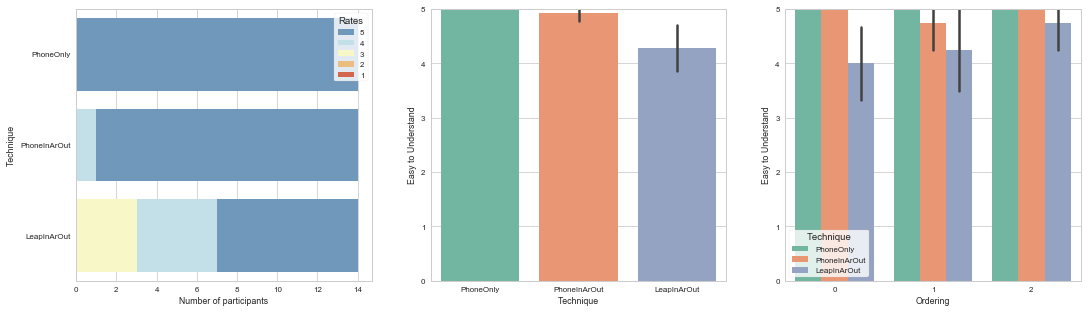

In [530]:
displayParticipantsCounts(counts.loc['rates', :], 'easy_understand')

The *LeapInArOut* technique is harder to understand than the others (like I hypothesised), particularly when it's the last technique tested (ordering 0).

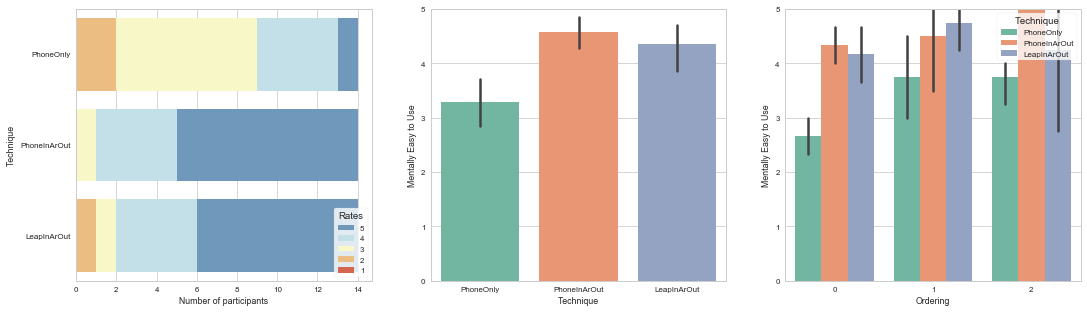

In [528]:
displayParticipantsCounts(counts.loc['rates', :], 'mentally_easy_use')

The *PhoneOnly* technique is mentally more difficult to use than the others, particularly when it's the first technique tested (ordering 0). I expected the *PhoneInArOut* technique to be the simpler to use mentally.

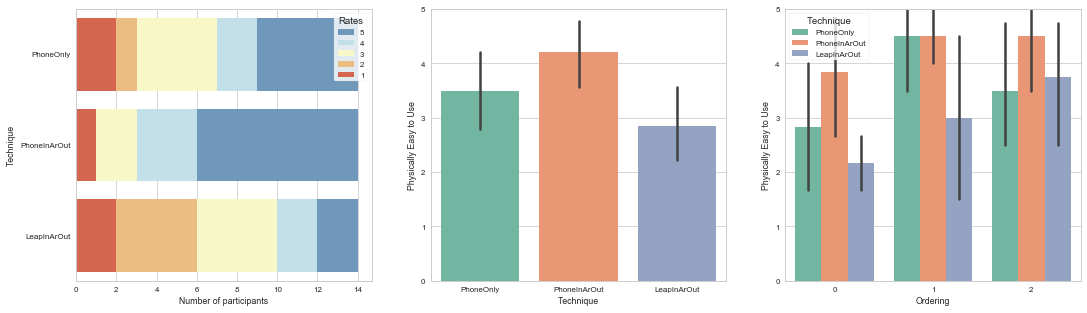

In [529]:
displayParticipantsCounts(counts.loc['rates', :], 'physically_easy_use')

The *LeapInArOut* technique is more tiring than the others (like I hypothesised), particularly when it's the last technique tested (ordering 0). I also expected the *PhoneInArOut* technique to be less tiring.

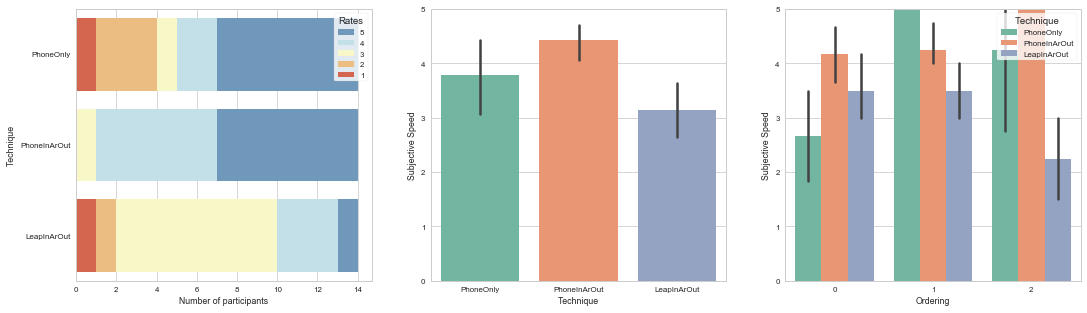

In [532]:
displayParticipantsCounts(counts.loc['rates', :], 'could_go_fast')

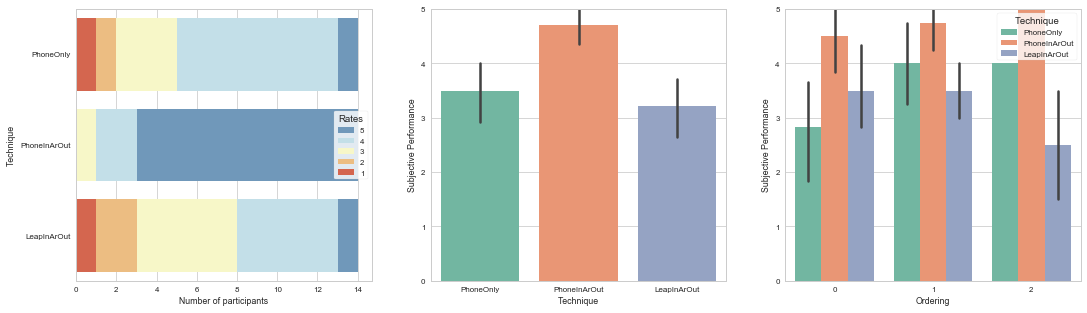

In [533]:
displayParticipantsCounts(counts.loc['rates', :], 'subjective_performance')

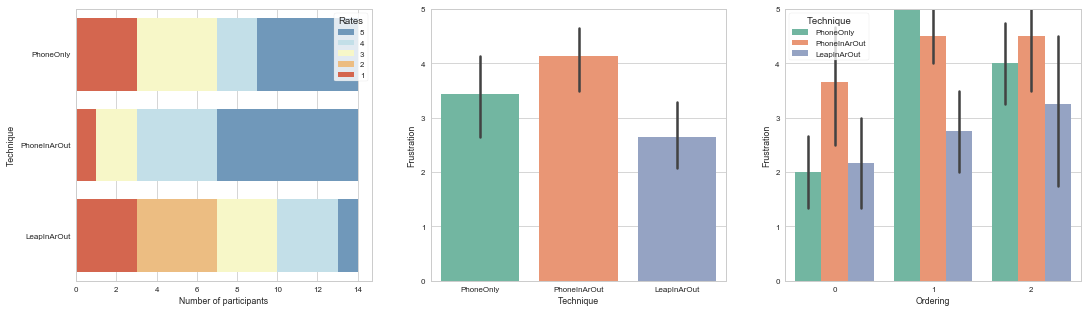

In [534]:
displayParticipantsCounts(counts.loc['rates', :], 'frustration')

Visualize the participants preferences:

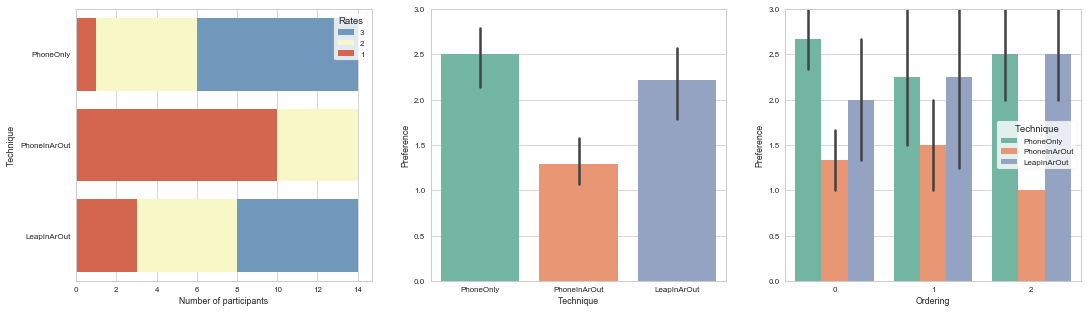

In [535]:
displayParticipantsCounts(counts.loc['preferences', :], 'preference')

## Analysis of the trials

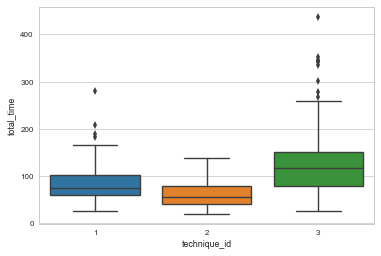

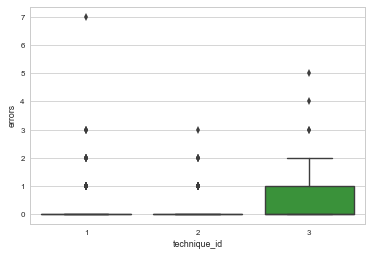

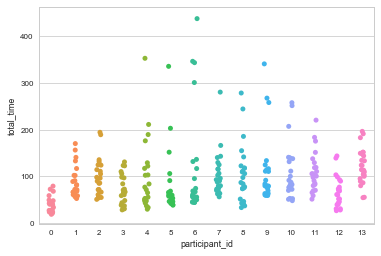

In [536]:
sns.boxplot(x='technique_id', y='total_time', data=trials);

plt.figure()
sns.boxplot(x='technique_id', y='errors', data=trials);

plt.figure()
sns.stripplot(x='participant_id', y='total_time', data=trials, jitter=True);

## Bonus

Visualize the distribution accross all the trials of the items to classify:

In [ ]:
grid_cols, grid_rows, grid_items_count = 5, 3, 5
trials['grid_config'] = trials['grid_config'].apply(lambda grid_config: literal_eval(grid_config) if grid_config is str else grid_config)

def countGridItemsToClassify(participant_ids):
    grid_counts = pd.DataFrame(0, columns=range(grid_cols), index=range(grid_rows))
    for index, grid_config in trials.loc[trials['participant_id'].isin(participant_ids), 'grid_config'].iteritems():
        for i in range(grid_rows):
            for j in range(grid_cols):
                if grid_config[i][j][0] == grid_config[i][j][grid_items_count - 1]:
                    grid_counts.iat[i, j] = grid_counts.iat[i, j] + 1
    return grid_counts


sns.heatmap(countGridItemsToClassify(participant_ids), vmin=0, annot=True, fmt='d', cmap='YlGnBu')